## COVID19 Global Forecasting (Week 1) Covid-19 全球確診死亡人數預測 第一週
- 在這一挑戰中，您將預測世界各地各個地區未來日期的確認Covid19案例的累積數量，以及導致死亡的數量。

### 評估
- 兩個 column，分別為確診人數 (ConfirmedCases)、死亡人數 (Fatalities)
- 評估指標 RMSLE

In [94]:
# 事前準備
import os
import numpy as np          # 資料處理分析工具
import pandas as pd         # 資料處理分析工具
from scipy import stats     # 統計函式庫
from scipy.stats import norm, skew
from collections import Counter # counter是字典，用來計數，key是要計數的item，value儲存的是個數
from sklearn.preprocessing import LabelEncoder # 用於特徵提取, 將數值資料轉為離散
from sklearn.preprocessing import MinMaxScaler

# 匯入必要的函式庫
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

import datetime as dt
import string
from google.cloud import bigquery

# 資料視覺化
import matplotlib.pyplot as plt
from matplotlib import rcParams, pyplot as plt, style as style
%matplotlib inline
import seaborn as sns
color = sns.color_palette() # 生成各種顏色
sns.set_style('darkgrid') # 設置主題：darkgrid、whitegrid、dark、white、ticks
# 設定展示欄位最大值
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)

# 忽略警告
import warnings
warnings.filterwarnings("ignore")

In [95]:
# 載入訓練資料集
train = pd.read_csv("./data/covid19-global-forecasting-week-1/train.csv")
train.head(5)

,Id,Province/State,Country/Region,Lat,Long,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,33.0,65.0,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,33.0,65.0,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,33.0,65.0,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,33.0,65.0,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,33.0,65.0,2020-01-26,0.0,0.0


In [96]:
# 載入測試資料集
test = pd.read_csv('./data/covid19-global-forecasting-week-1/test.csv')
test.head(5)

,ForecastId,Province/State,Country/Region,Lat,Long,Date
0,1,NaN,Afghanistan,33.0,65.0,2020-03-12
1,2,NaN,Afghanistan,33.0,65.0,2020-03-13
2,3,NaN,Afghanistan,33.0,65.0,2020-03-14
3,4,NaN,Afghanistan,33.0,65.0,2020-03-15
4,5,NaN,Afghanistan,33.0,65.0,2020-03-16


In [97]:
# 確認資料特徵類型
print(f'train dtypes:\n{train.dtypes}')
print(f'\ntrain shape: {train.shape}')
print(f'\ntest shape: {test.shape}')

train dtypes:
Id                  int64
Province/State     object
Country/Region     object
Lat               float64
Long              float64
Date               object
ConfirmedCases    float64
Fatalities        float64
dtype: object

train shape: (17892, 8)

test shape: (12212, 6)


### [ 分析目標 ]
- 透過地點、日期 來判斷確診與死亡人數
- 日期區間為 2020-01-22 至 2020-03-24
- 了解個國家確診占比後發現,中國、義大利、美國，這三國確診人數初期最多
- 中國從 2020-02-11 後人數暴增，其餘國家大約 2020-03-11 後人數暴增
- 義大利的死亡人數從 2020-03-11 後暴增，2020-03-17 超越中國成為死亡人數最多的國家

In [98]:
#觀察各國確診死亡情形
country_province = train.fillna('N/A').groupby(['Country/Region','Province/State'])['ConfirmedCases', 'Fatalities'].max().sort_values(by='ConfirmedCases', ascending=False)
country_province

ConfirmedCases  Fatalities
Country/Region Province/State                            
Italy          N/A                    69176.0      6820.0
China          Hubei                  67801.0      3160.0
Spain          N/A                    39885.0      2808.0
Germany        N/A                    32986.0       157.0
US             New York               25681.0       210.0
...                                       ...         ...
Puerto Rico    N/A                        0.0         0.0
China          Yunnan                     0.0         0.0
               Heilongjiang               0.0         0.0
               Henan                      0.0         0.0
               Shanghai                   0.0         0.0

[284 rows x 2 columns]

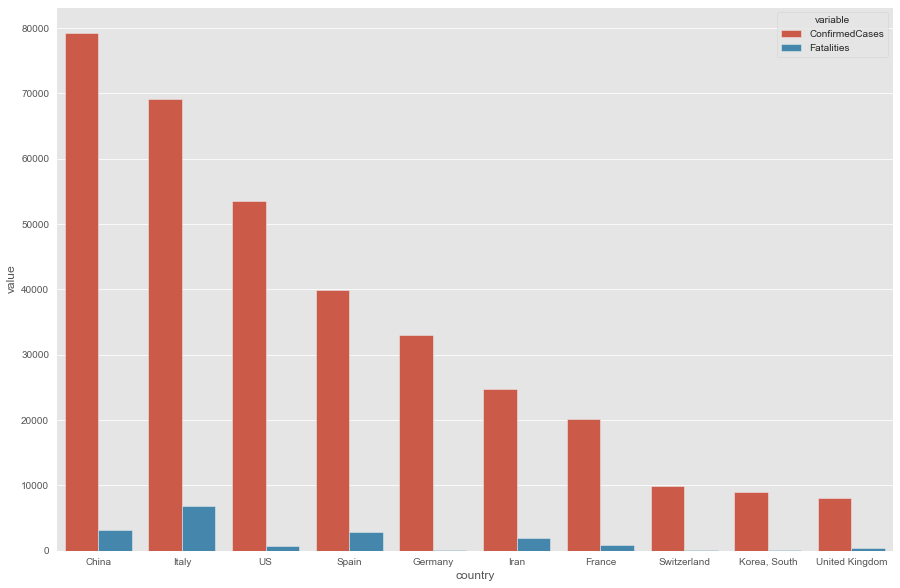

In [99]:
# Aggregate records by countries
countries = country_province.groupby('Country/Region')['ConfirmedCases','Fatalities'].sum().sort_values(by= 'ConfirmedCases',ascending=False)

countries['country'] = countries.index

# Unpivot the dataframe from wide to long format
df_long = pd.melt(countries, id_vars=['country'] , value_vars=['ConfirmedCases','Fatalities'])

#Top countries by confirmed cases
top_countries = countries.index[:10]

df_top_countries = df_long[df_long['country'].isin(top_countries)]

style.use('ggplot')
rcParams['figure.figsize'] = 15,10
ax = sns.barplot(x = 'country', hue="variable", y="value", data=df_top_countries)

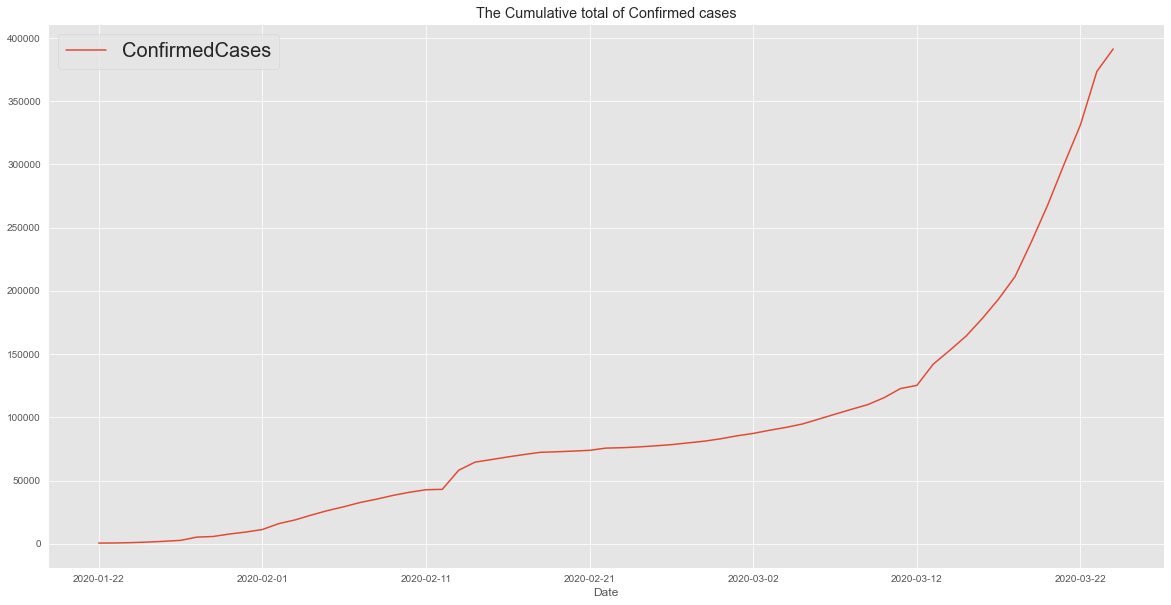

In [100]:
# 時間序列分析 (確診人數)
train.Date.min(), train.Date.max()
# Remove columns we do not need
cols_ConfirmedCases = ['Lat', 'Long', 'Fatalities']
times_series_ConfirmedCases = train.drop(cols_ConfirmedCases, axis=1).fillna('N/A')

# Aggregate cases by date and country
times_series_ConfirmedCases = times_series_ConfirmedCases.groupby(['Date','Province/State','Country/Region'])['ConfirmedCases'].max()\
                    .groupby(['Date','Country/Region']).sum()\
                    .reset_index()

# Indexing with Time Series Data
times_series_ConfirmedCases = times_series_ConfirmedCases.set_index('Date')

times_series_ConfirmedCases_df = times_series_ConfirmedCases.groupby('Date')['ConfirmedCases'].sum().reset_index()
times_series_ConfirmedCases_df = times_series_ConfirmedCases_df.set_index('Date')

# 查看確診人數與日期的關係
times_series_ConfirmedCases_df.plot(figsize=(20, 10), title="The Cumulative total of Confirmed cases")
plt.legend(loc=2, prop={'size': 20})
plt.show()

In [ ]:
# 各國 確診人數與日期的關係
top_countries_ConfirmedCases = times_series_ConfirmedCases[times_series_ConfirmedCases['Country/Region'].isin(top_countries)]
plt.xticks(rotation=45)

ax = sns.lineplot(x=top_countries_ConfirmedCases.index, y="ConfirmedCases", hue="Country/Region", data=top_countries_ConfirmedCases).set_title('Cumulative line')
plt.legend(loc=2, prop={'size': 12})

In [ ]:
# 時間序列分析 (確診人數)
train.Date.min(), train.Date.max()
# Remove columns we do not need
cols_Fatalities = ['Lat', 'Long', 'ConfirmedCases']
times_series_Fatalities = train.drop(cols_Fatalities, axis=1).fillna('N/A')

# Aggregate cases by date and country
times_series_Fatalities = times_series_Fatalities.groupby(['Date','Province/State','Country/Region'])['Fatalities'].max()\
                    .groupby(['Date','Country/Region']).sum()\
                    .reset_index()

# Indexing with Time Series Data
times_series_Fatalities = times_series_Fatalities.set_index('Date')

times_series_Fatalities_df = times_series_Fatalities.groupby('Date')['Fatalities'].sum().reset_index()
times_series_Fatalities_df = times_series_Fatalities_df.set_index('Date')

# 查看確診人數與日期的關係
times_series_Fatalities_df.plot(figsize=(20, 10), title="The Cumulative total of Fatalities cases")
plt.legend(loc=2, prop={'size': 20})
plt.show()

In [ ]:
# 各國 確診人數與日期的關係
top_countries_Fatalities = times_series_Fatalities[times_series_Fatalities['Country/Region'].isin(top_countries)]
plt.xticks(rotation=45)

ax = sns.lineplot(x=top_countries_Fatalities.index, y="Fatalities", hue="Country/Region", data=top_countries_Fatalities).set_title('Cumulative line')
plt.legend(loc=2, prop={'size': 12})

#### 1. 特徵建構
- 新增城市數 特徵
- 填補缺失值
- 轉換時間特徵

In [ ]:
arr1 = train['Country/Region'].unique()
arr2 = arr2 = [i for i in range(163)]

country_dict = dict(zip(arr1, arr2))
data = [train, test]
for dataset in data:
    dataset['Country_int'] = dataset['Country/Region'].map(country_dict).astype(int)
    
for j in train['Country/Region'].unique():
    l = train[(train['Country/Region'] == j)]
    len_state = len(l['Province/State'].unique())
    
    if len_state != 1:
        arr_state1 = l['Province/State'].unique()
        arr_state2 = [i for i in range(1,len_state+1)]
        state_dict = dict(zip(arr_state1, arr_state2))

        for dataset in data:
            dataset['Province/State'] = dataset['Province/State'].map(state_dict)
            
train.head()            

In [ ]:
for dataset in data:
    dataset['Province/State'].fillna(0, inplace=True)
    
test.head()    

In [ ]:
# 相關性分析
train_corr = train.drop(['Id'],axis=1)
corr = train_corr.corr()
plt.figure(figsize=(11,7))
sns.heatmap(corr, annot=True)

In [ ]:
# 將時間特徵轉為數字 , 因為日期一天一天往後 可以當作大小判斷
train["Date"] = train["Date"].apply(lambda x: x.replace("-",""))
train["Date"]  = train["Date"].astype(int)
train.head()

In [ ]:
# 拿掉 NaN 值
train = train.drop(['Province/State'],axis=1)
train = train.dropna()
train.isnull().sum()

In [ ]:
# 測試集 同步
test["Date"] = test["Date"].apply(lambda x: x.replace("-",""))
test["Date"]  = test["Date"].astype(int)
test = test.dropna()
test.isnull().sum()

In [ ]:
# 針對地區做 one-hot encode
# train = pd.concat([train, pd.get_dummies(train["Country/Region"])], axis=1)
# test = pd.concat([test, pd.get_dummies(test["Country/Region"])], axis=1)

## 建立模型
- 建立需要用到的模型, 再利用交叉驗證判斷好壞
- 先預測確診人數，再預測死亡人數

In [ ]:
x = train.drop(['Id','Country/Region','ConfirmedCases','Fatalities'],axis=1)

y1 = train[['ConfirmedCases']]
y2 = train[['Fatalities']]

x_test = test.drop(['ForecastId','Province/State','Country/Region'],axis=1)

print(f'x shape: {x.shape}')
print(f'y1 shape: {y1.shape}')
print(f'y2 shape: {y2.shape}')
print(f'test shape: {x_test.shape}')

In [ ]:
Tree_model = RandomForestRegressor(n_estimators=300, min_samples_split=9, min_samples_leaf=10, 
                           max_features='sqrt', max_depth=8, bootstrap=False)


In [ ]:
print(f'x shape: {x.shape}')
print(f'y1 shape: {y1.shape}')
print(f'y2 shape: {y2.shape}')
print(f'test shape: {x_test.shape}')

In [ ]:
# 訓練 確診人數
Tree_model.fit(x,y1)
pred1 = Tree_model.predict(x_test)
pred1 = pd.DataFrame(pred1)

In [ ]:
# 訓練 死亡人數
Tree_model.fit(x,y2)
pred2 = Tree_model.predict(x_test)
pred2 = pd.DataFrame(pred2)

In [ ]:
sub = pd.read_csv('./data/covid19-global-forecasting-week-1/submission.csv')
submission = pd.DataFrame()
submission['ForecastId'] = sub['ForecastId']
submission['ConfirmedCases'] = lgb_pred 
submission['Fatalities'] = lgb_pred2 
submission["ConfirmedCases"] = submission["ConfirmedCases"].astype(int)
submission["Fatalities"] = submission["Fatalities"].astype(int)

submission.to_csv('./data/covid19-global-forecasting-week-1/submission_blend.csv', index = False)